# Evaluate models and test relationship to neural measures

Use Bayesian statistics to evaluate different candidate reaction time models based on the linear ballistic accumulator (LBA) framework. Compare the models to determine the best one after controlling for model complexity. Then examine model parameters to test how they are related to neural measures related to cognitive maps of the task.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pymc3 as pm
import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from nireact import task, lba, model
fig_dir = '/Users/morton/Dropbox/work/mistr/figs3'
lba_dir = '/Users/morton/Dropbox/work/mistr/batch/lba2'
model_dir = os.path.join(fig_dir, 'model')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## Load data

Include direct (AB, BC) and inference (AC) tests. For each test type, remove extreme values that are greater than median + 5 * IQR.

In [2]:
# load RT data, scrub extreme values
data_dir = '/Users/morton/work/mistr'
raw = task.read_test_all_subj(data_dir)
thresh = raw.groupby('test_type').agg(lambda x: np.median(x) + 5 * st.iqr(x))
data = task.scrub_rt(raw, thresh=thresh)
data.loc[:, 'source'] = 'data'

In [3]:
# unpack data variables
rt = data.rt.values
response = data.response.values
test = data.test_type.values
subj_idx = data.subj_idx.values
n_subj = len(np.unique(subj_idx))

# Define and estimate models

For each model, initialize a hierarchical graph and estimate the posterior distribution of the parameters.

### Full model

Evaluate the full ("navigation") model.

In [4]:
# compile model
model_nav = lba.LBANav()
graph_nav = model_nav.init_graph_hier(rt, response, test, subj_idx)

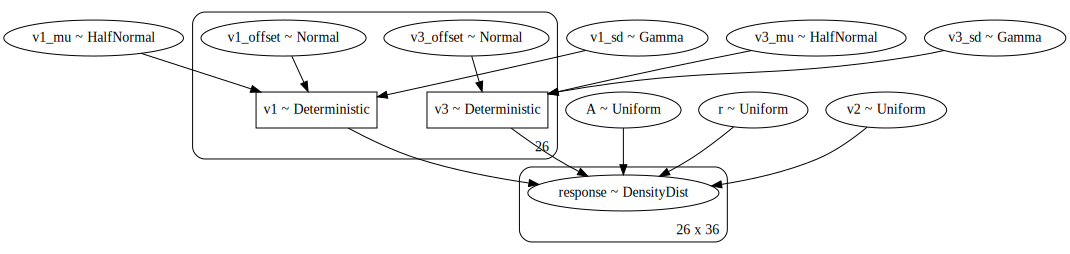

In [5]:
# visualize model graph
dot = pm.model_to_graphviz(graph_nav)
dot.render(os.path.join(model_dir, 'graph_nav'))
dot

In [6]:
# sample from the posterior distribution
trace_nav = pm.sample(10000, tune=5000, target_accept=.95, model=graph_nav)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v3_offset, v3_sd, v3_mu, r, v2, v1_offset, v1_sd, v1_mu, A]
Sampling 4 chains, 2 divergences: 100%|██████████| 60000/60000 [22:38<00:00, 44.18draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/morton/anaconda3/envs/mistr/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


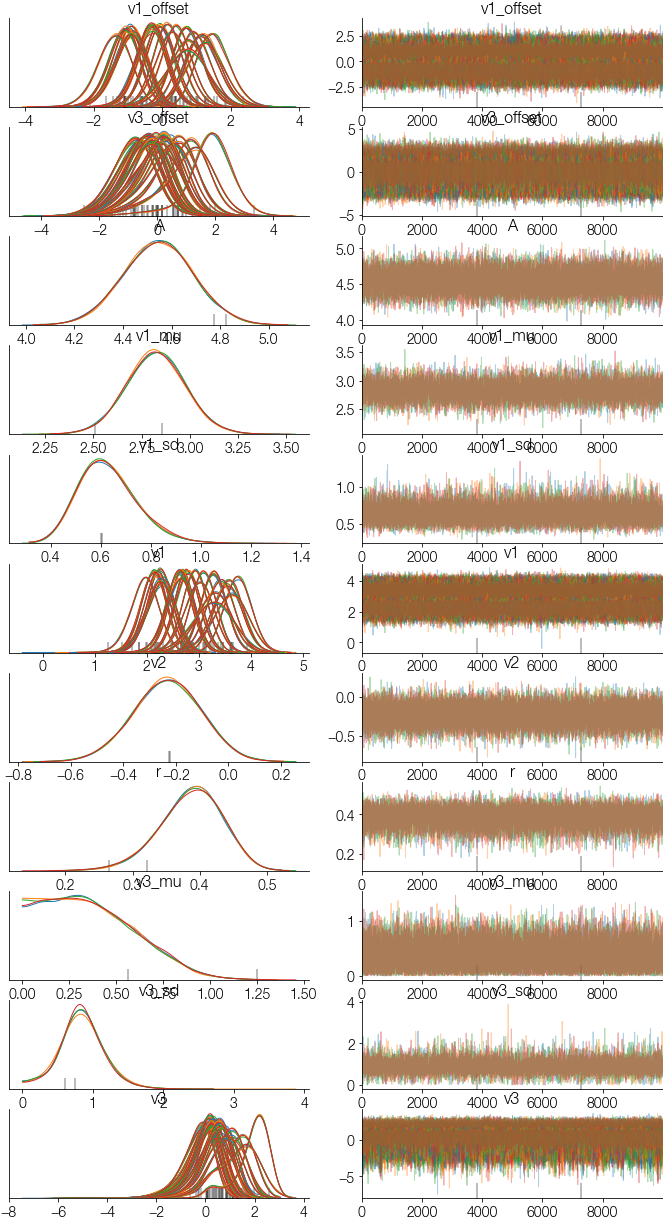

In [7]:
# visualize the sampling to check for convergence
h = pm.traceplot(trace_nav)

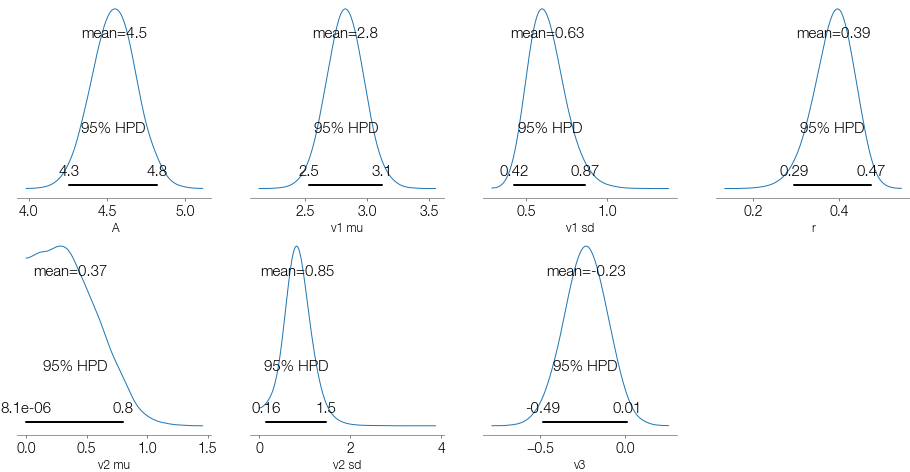

In [8]:
# plot posterior estimates of parameters
fig, axes = plt.subplots(2, 4, figsize=(16, 8), tight_layout=False, constrained_layout=False)
var_names = ['A', 'v1_mu', 'v1_sd', 'r', 'v3_mu', 'v3_sd', 'v2']
var_labels = ['A', 'v1 mu', 'v1 sd', 'r', 'v2 mu', 'v2 sd', 'v3']
h = pm.plot_posterior(trace_nav, var_names=var_names,
                      credible_interval=.95, ax=axes)

for ax, label in zip(fig.axes, var_labels):
    ax.set_title('')
    ax.set_xlabel(label)
fig.delaxes(axes[1, 3])
fig.savefig(os.path.join(model_dir, 'lba_nav_post.pdf'))

In [9]:
# save the trace to disk
o = pm.save_trace(trace_nav, os.path.join(lba_dir, 'nav_hier'), 
                  overwrite=True)

ess = pm.stats.ess(trace_nav)
ess.to_netcdf(os.path.join(lba_dir, 'nav_hier_ess.nc'))

rhat = pm.rhat(trace_nav)
rhat.to_netcdf(os.path.join(lba_dir, 'nav_hier_rhat.nc'))

In [10]:
df_rhat = model.summarize_trace_stats(rhat)
print(f"max rhat: {df_rhat['max'].max()}")

df_ess = model.summarize_trace_stats(ess)
print(f"min ess: {df_ess['min'].min()}")

max rhat: 1.0005373095729475
min ess: 6966.372863718298


In [11]:
# run posterior predictive sampling
param, subj_param = model_nav.post_param(trace_nav)
sim = model_nav.gen(test, param, subj_idx, nrep=50, subj_param=subj_param)
fit_nav = task.scrub_rt(sim, thresh=thresh)

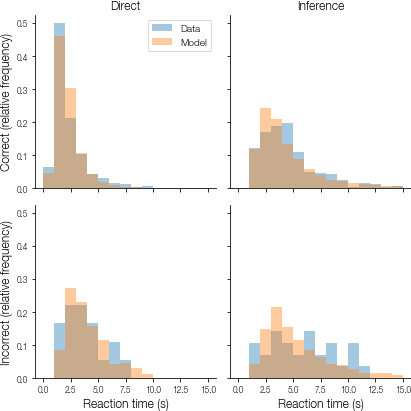

In [12]:
g = model.plot_fit(data, fit_nav)
g.savefig(os.path.join(model_dir, 'lba_nav_fit.pdf'))

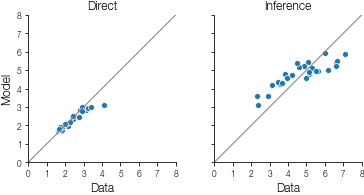

In [13]:
g = model.plot_fit_scatter(data, fit_nav)
g.savefig(os.path.join(model_dir, 'lba_nav_scatter.pdf'))

### Variable drift model

A special case of the full model where v3 and v4 are not included. There is one process that varies in drift rate depending on whether the test trial is direct (v=v1) or inference (v=v1 * r).

In [14]:
model_var = lba.LBAVar()
graph_var = model_var.init_graph_hier(rt, response, test, subj_idx)

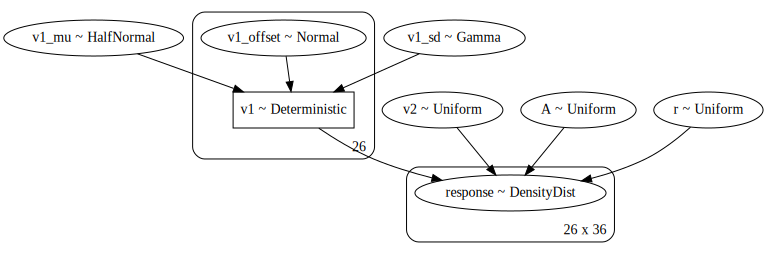

In [15]:
dot = pm.model_to_graphviz(graph_var)
dot.render(os.path.join(model_dir, 'graph_var'))
dot

In [16]:
trace_var = pm.sample(10000, tune=5000, target_accept=.95, model=graph_var)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, v2, v1_offset, v1_sd, v1_mu, A]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [05:44<00:00, 174.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/morton/anaconda3/envs/mistr/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


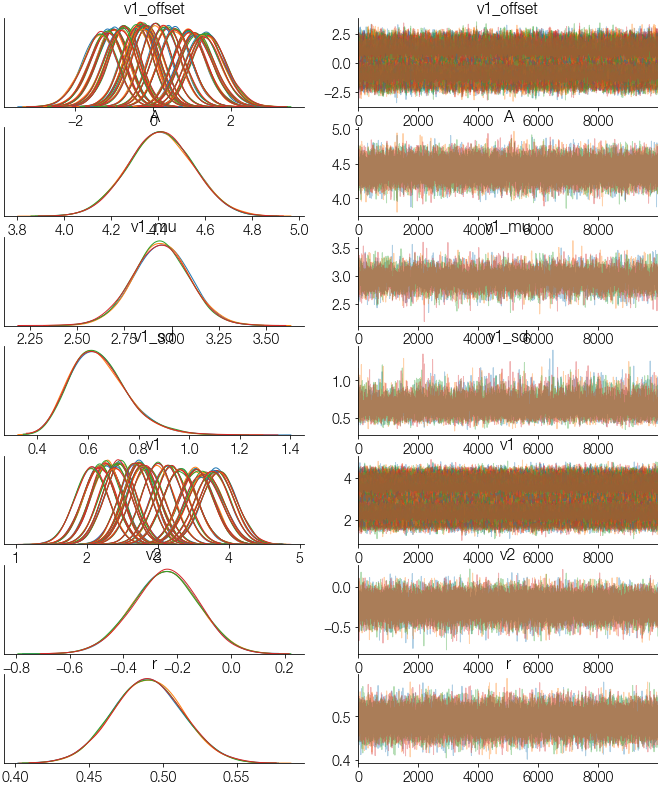

In [17]:
h = pm.traceplot(trace_var)

In [48]:
o = pm.save_trace(trace_var, os.path.join(lba_dir, 'var_hier'), 
                  overwrite=True)

rhat = pm.rhat(trace_var)
rhat.to_netcdf(os.path.join(lba_dir, 'var_hier_rhat.nc'))

ess = pm.stats.ess(trace_nav)
ess.to_netcdf(os.path.join(lba_dir, 'nav_hier_ess.nc'))

In [49]:
df_rhat = model.summarize_trace_stats(rhat)
print(f"max rhat: {df_rhat['max'].max()}")

df_ess = model.summarize_trace_stats(ess)
print(f"min ess: {df_ess['min'].min()}")

max rhat: 1.0007631176894363
min ess: 6966.372863718298


In [19]:
param, subj_param = model_var.post_param(trace_var)
sim = model_var.gen(test, param, subj_idx, nrep=50, subj_param=subj_param)
fit_var = task.scrub_rt(sim, thresh=thresh)

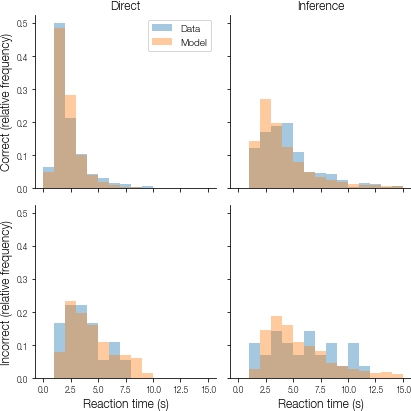

In [20]:
g = model.plot_fit(data, fit_var)
g.savefig(os.path.join(model_dir, 'lba_var_fit.pdf'))

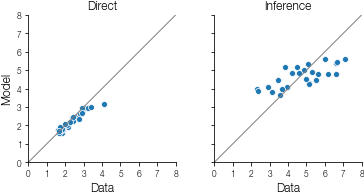

In [21]:
g = model.plot_fit_scatter(data, fit_var)
g.savefig(os.path.join(model_dir, 'lba_var_scatter.pdf'))

### Separate drift model

In contrast to the full model, the direct and inference trials are modeled using completely separate drift parameters.

In [22]:
model_sep = lba.LBASep()
graph_sep = model_sep.init_graph_hier(rt, response, test, subj_idx)

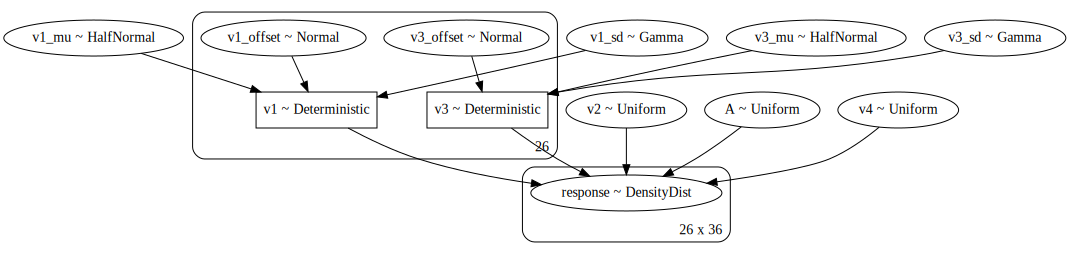

In [23]:
dot = pm.model_to_graphviz(graph_sep)
dot.render(os.path.join(model_dir, 'graph_sep'))
dot

In [24]:
trace_sep = pm.sample(10000, tune=5000, target_accept=.95, model=graph_sep)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v4, v3_offset, v3_sd, v3_mu, v2, v1_offset, v1_sd, v1_mu, A]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [06:44<00:00, 148.22draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/morton/anaconda3/envs/mistr/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


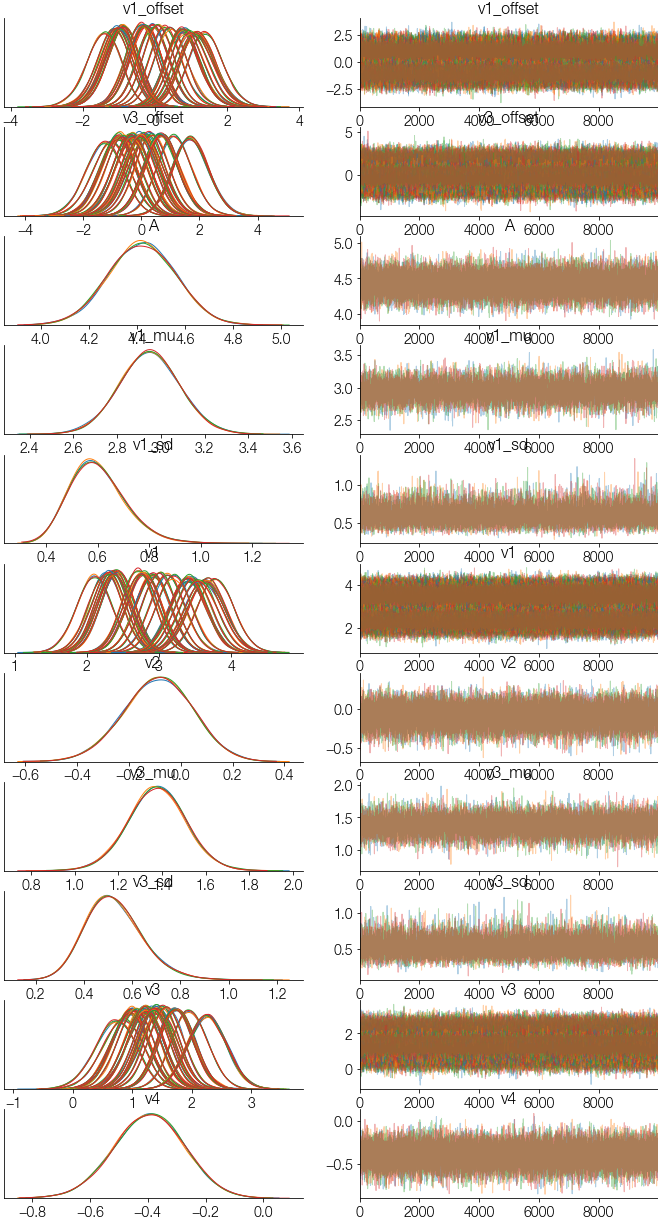

In [25]:
h = pm.traceplot(trace_sep)

In [26]:
o = pm.save_trace(trace_sep, os.path.join(lba_dir, 'sep_hier'), 
                  overwrite=True)
rhat = pm.rhat(trace_sep)
rhat.to_netcdf(os.path.join(lba_dir, 'sep_hier_rhat.nc'))

In [27]:
param, subj_param = model_sep.post_param(trace_sep)
sim = model_sep.gen(test, param, subj_idx, nrep=50, subj_param=subj_param)
fit_sep = task.scrub_rt(sim, thresh=thresh)

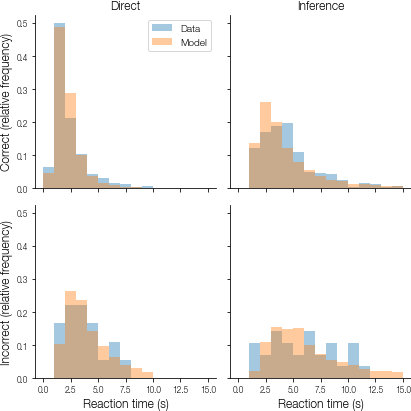

In [28]:
g = model.plot_fit(data, fit_sep)
g.savefig(os.path.join(model_dir, 'lba_sep_fit.pdf'))

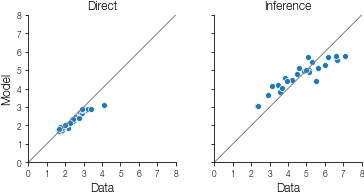

In [29]:
g = model.plot_fit_scatter(data, fit_sep)
g.savefig(os.path.join(model_dir, 'lba_sep_scatter.pdf'))

## Select the best model

Use leave-one-out (LOO) model selection to determine which best fits the model after taking complexity into account.

In [30]:
loo = pm.compare({'var': trace_var, 'nav': trace_nav, 'sep': trace_sep}, 
                 ic='LOO', method='BB-pseudo-BMA', b_samples=100000)
loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
nav,0,3435.17,36.59,0,0.960154,85.1647,0,False,deviance
sep,1,3449.23,40.5821,14.0603,0.0359762,85.3566,7.08817,False,deviance
var,2,3451.4,28.71,16.2266,0.00386964,85.2457,4.71811,False,deviance


In [31]:
loo = pm.compare({'var': trace_var, 'nav': trace_nav}, 
                 ic='LOO', method='BB-pseudo-BMA', b_samples=100000)
loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
nav,0,3435.17,36.59,0,0.996003,84.9118,0,False,deviance
var,1,3451.4,28.71,16.2266,0.00399735,84.8301,4.71811,False,deviance


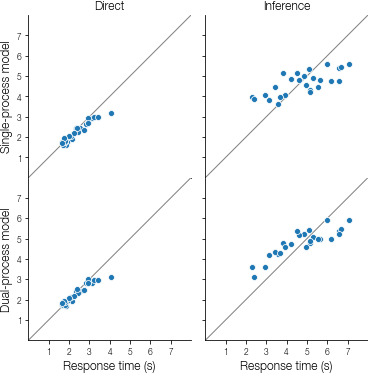

In [47]:
model_names = ['Single-process model', 'Dual-process model']
g = model.plot_fit_scatter_comp(data, fit_var, fit_nav, model_names)
g.savefig(os.path.join(model_dir, 'lba_comp_fit.pdf'))